In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ADFTest
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
df = pd.read_csv("../../data library/Trigo_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)

# df['seasonal_feature'] = df['Data'].apply(lambda x: seasonal_pattern(x))
# df['trend_feature'] = df['Data'].apply(lambda x: trend_pattern(x))

df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0


In [3]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [4]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [5]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['Estadual'].shift(1)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0,2.905457,175.4,24.9,NaN
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0,3.036777,38.0,22.2,30.2614


In [6]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])

df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

In [7]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

In [8]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def xg_model(X_train, y_train, X_test):
    cv_split = TimeSeriesSplit(n_splits=2, test_size=len(X_test)-24)
    model = XGBRegressor(n_estimators=1000)
    parameters = {
        "max_depth": [3, 4, 6, 5, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "n_estimators": [100, 300, 500, 700, 900, 1000],
        "colsample_bytree": [0.3, 0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)

    return predictions

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  _, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

Variáveis

In [10]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])

end = df2.Data.iat[-1]
K = 24
 
date_generated = pd.date_range(end, periods=K, freq="MS")
expand_df = pd.DataFrame(date_generated, columns=["Data"])

df2 = pd.concat([df2, expand_df], ignore_index=True)

df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int((len(df2)-K)*0.8))].copy()
test_df = df2[(int((len(df2)-K)*0.8)):].copy()

In [11]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["País"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["País"]

In [12]:
pred = xg_model(X_train, y_train, X_test)

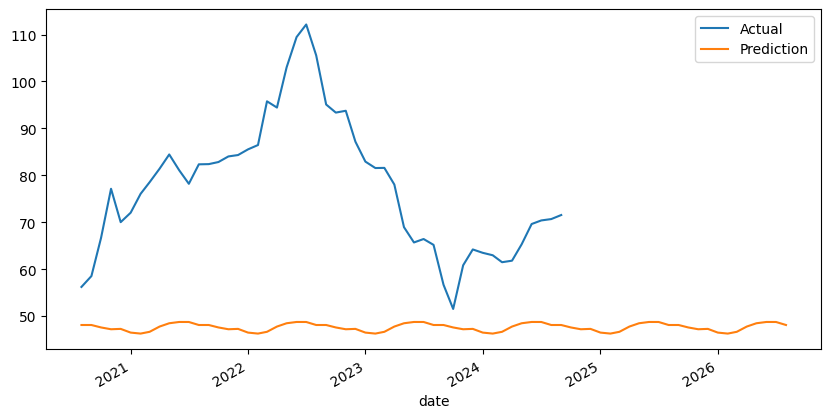

In [13]:
plot_predictions(testing_dates, y_test, pred)
df_test_pred = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred})

In [14]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "País"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "País"]]
y_test = testing_data["Estadual"]

In [15]:
pred = xg_model(X_train, y_train, X_test)

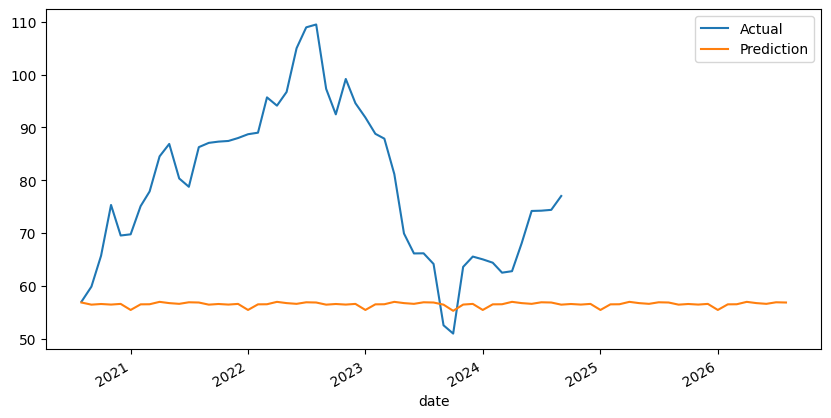

MAE: 22.996077348876952
RMSE: 26.82580954328995
MAPE: 0.2678996426921727
R-Squared: -2.468682335309667


In [16]:
plot_predictions(testing_dates, y_test, pred)
evaluate_model(y_test[:50], pred[:50])

In [17]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "USD"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "USD"]]
y_test = testing_data["Estadual"]

In [18]:
pred = xg_model(X_train, y_train, X_test)

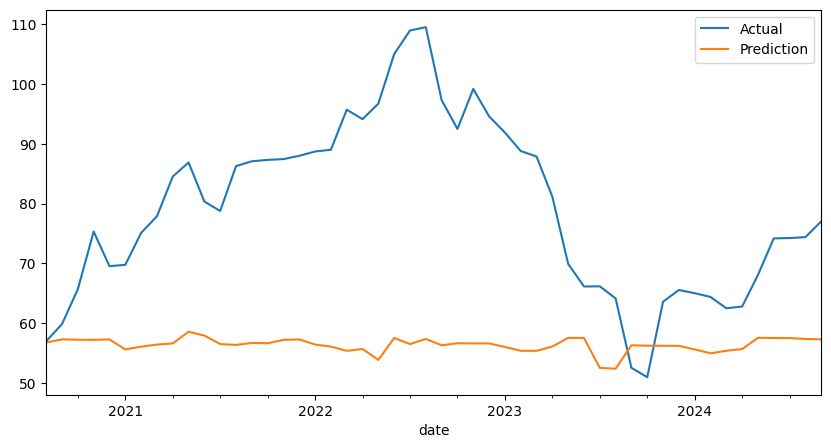

MAE: 23.163536760498047
RMSE: 26.922159419032656
MAPE: 0.270495836243805
R-Squared: -2.4936439153063734


In [19]:
plot_predictions(testing_dates[:50], y_test[:50], pred[:50])
evaluate_model(y_test[:50], pred[:50])

In [20]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "USD", "Precipitacao"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "USD", "Precipitacao"]]
y_test = testing_data["Estadual"]

In [22]:
pred = xg_model(X_train, y_train, X_test)

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


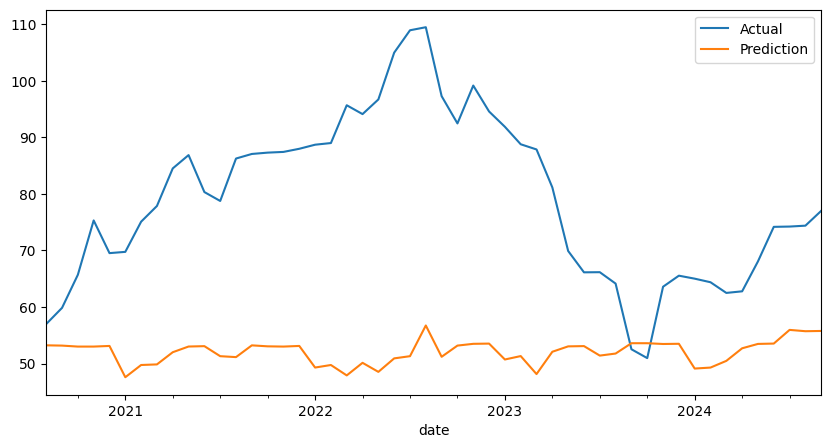

MAE: 27.269933778930664
RMSE: 30.91799284792592
MAPE: 0.3216095009100796
R-Squared: -3.607670765525162


In [23]:
plot_predictions(testing_dates[:50], y_test[:50], pred[:50])
evaluate_model(y_test[:50], pred[:50])

In [24]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "USD", "País"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "USD", "País"]]
y_test = testing_data["Estadual"]

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


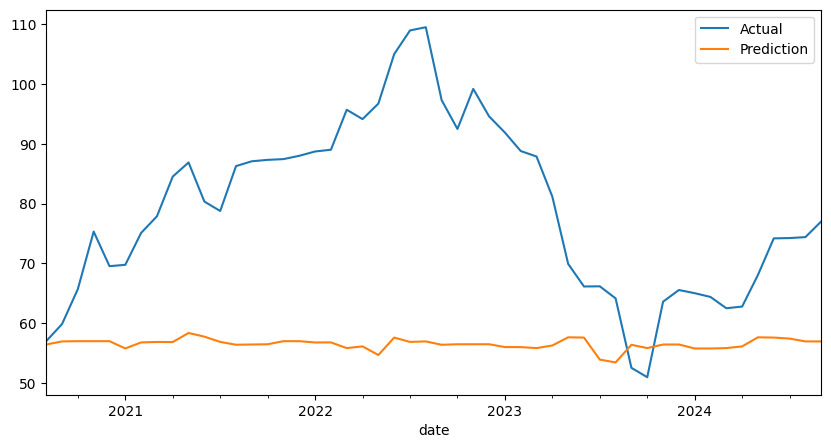

MAE: 23.016187975097655
RMSE: 26.80370261278633
MAPE: 0.2684814664746014
R-Squared: -2.4629676654332204


In [25]:
pred = xg_model(X_train, y_train, X_test)

plot_predictions(testing_dates[:50], y_test[:50], pred[:50])
evaluate_model(y_test[:50], pred[:50])

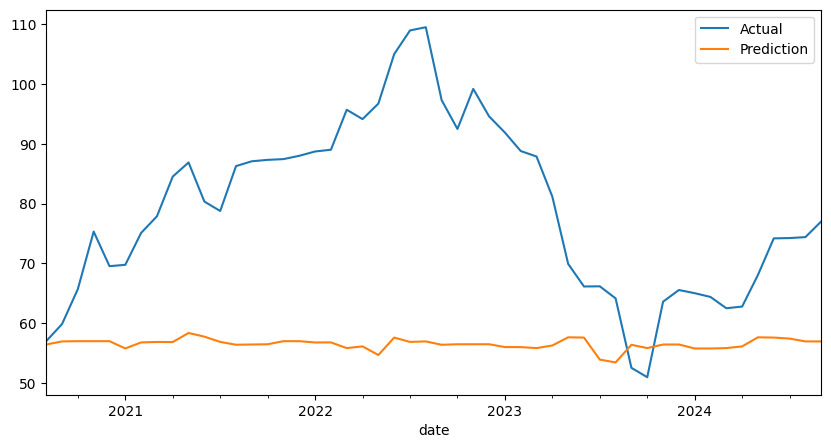

MAE: 23.016187975097655
RMSE: 26.80370261278633
MAPE: 0.2684814664746014
R-Squared: -2.4629676654332204


In [26]:
plot_predictions(testing_dates[:50], y_test[:50], pred[:50])
evaluate_model(y_test[:50], pred[:50])

In [27]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "USD", "País", "Precipitacao", "lag_Estadual"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "USD", "País", "Precipitacao", "lag_Estadual"]]
y_test = testing_data["Estadual"]

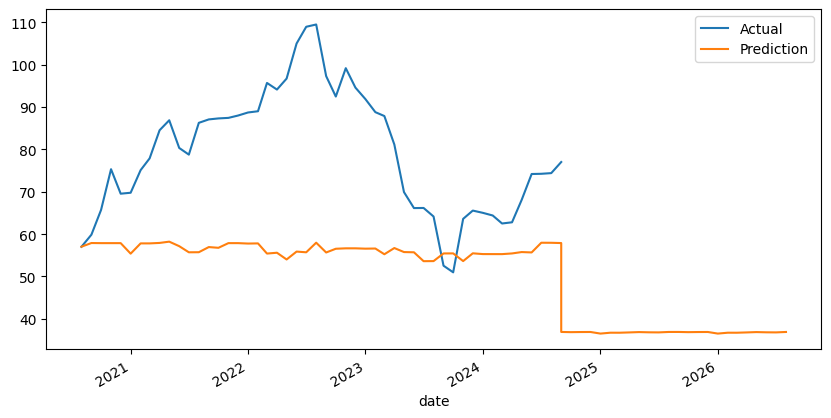

MAE: 23.102912046264645
RMSE: 26.86173939219675
MAPE: 0.26971566484956183
R-Squared: -2.4779802985059924


In [28]:
pred = xg_model(X_train, y_train, X_test)

plot_predictions(testing_dates, y_test, pred)
evaluate_model(y_test[:50], pred[:50])